In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tag import PerceptronTagger
from nltk.corpus import stopwords
from nltk.data import find
from collections import Counter
from tqdm import tqdm
import sklearn.metrics as metrics
import sklearn
import pandas as pd
import numpy as np
import operator
import nltk
import math
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# nltk.download('vader_lexicon')
# nltk.download("averaged_perceptron_tagger")

C:\Anaconda\envs\py35\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to C:\Windows\ServicePro
[nltk_data]     files\LocalService\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to C:\Windo
[nltk_data]     ws\ServiceProfiles\LocalService\AppData\Roaming\nltk_d
[nltk_data]     ata...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

## Q1. Sentiment Analysis and Aggregation

## Q1 (a)

In [2]:
data = pd.read_csv('reviews.csv', header=None)
data.columns=['idNum', 'filePath', 'hotelName', 'reviewCol', 'ratingScore', 'groundTruth']
data.head()

,idNum,filePath,hotelName,reviewCol,ratingScore,groundTruth
0,116832168,data\ca\154948\1146548\117749080.html,Evolution,The layout is extremely functional and astheti...,5,positive
1,117803689,data\ca\154948\1146548\118268031.html,Evolution,This is the second time this summer we stayed ...,4,positive
2,118268031,data\ca\154948\1146548\119564117.html,Evolution,"I really like this hotel, the decor is very mo...",5,positive
3,119564117,data\ca\154948\1146548\121167484.html,Evolution,We went to Whistler for the first time at the ...,5,positive
4,125313857,data\ca\154948\1146548\125351897.html,Evolution,Just returned from 8 days at Evolution. The pr...,5,positive


In [3]:
def evalSentences(df, columns=[]):
    sid = SentimentIntensityAnalyzer()
    pd_list = []
    for index, row in df.iterrows():
        ss = sid.polarity_scores(str(row['reviewCol']))
        pd_list.append([row['hotelName']]+[row['reviewCol']]+[ss['compound']]+[row['ratingScore']]+[row['groundTruth']])
    review_df = pd.DataFrame(pd_list)
    review_df.columns = columns
    return review_df

In [4]:
review_df = evalSentences(data, columns=['hotelName', 'reviewCol', 'vader', 'rating', 'groundTruth'])
review_cnt = review_df.hotelName.value_counts()
review_df = review_df.loc[review_df['hotelName'].isin(review_cnt[review_cnt>5].index)]

In [5]:
rank_df = review_df.groupby(['hotelName']).mean().reset_index()
rank_df.head()

,hotelName,vader,rating
0,Aava Whistler Hotel,0.820708,4.149171
1,Aspens on Blackcomb,0.655569,3.589744
2,Blackcomb Lodge,0.541523,3.708333
3,Carleton Lodge,0.857072,4.388889
4,Coast Blackcomb Suites at Whistler,0.728945,4.022727


## Q1 (b)

### Top-5 Average Vader Score

In [6]:
rank_df.nlargest(5, 'vader')

,hotelName,vader,rating
6,Delta Hotels by Marriott Whistler Village Suites,0.937752,4.521739
18,Nita Lake Lodge,0.932881,4.841137
11,Four Seasons Resort and Residences Whistler,0.911043,4.800000
23,Summit Lodge Boutique Hotel,0.877313,4.388571
20,Pan Pacific Whistler Village Centre,0.868842,4.652632


In [7]:
rank_df.nsmallest(5, 'vader')

,hotelName,vader,rating
30,Whistler Peak Lodge,0.176075,3.000000
16,Mountain Side Hotel Whistler by Executive,0.497600,3.363636
31,Whistler Village Inn + Suites,0.506621,3.606557
2,Blackcomb Lodge,0.541523,3.708333
29,Whistler Luxury Condos,0.611233,4.000000


### Top-5 Average Ground Truth Score

In [8]:
rank_df.nlargest(5, 'rating')

,hotelName,vader,rating
18,Nita Lake Lodge,0.932881,4.841137
11,Four Seasons Resort and Residences Whistler,0.911043,4.800000
10,First Tracks Lodge,0.819605,4.767857
19,Pan Pacific Whistler Mountainside,0.793395,4.712329
7,Evolution,0.844805,4.682927


In [9]:
rank_df.nsmallest(5, 'rating')

,hotelName,vader,rating
30,Whistler Peak Lodge,0.176075,3.000000
16,Mountain Side Hotel Whistler by Executive,0.497600,3.363636
8,Executive Inn At Whistler Village,0.665473,3.437500
1,Aspens on Blackcomb,0.655569,3.589744
31,Whistler Village Inn + Suites,0.506621,3.606557


The top-5 and bottom-5 results generally agree very well. A slight discrepancy is found in the order of bottom-5 for ground truth comparing to Vader.

## Q2. Frequency Analysis

## Q2 (a)

In [10]:
stop = set(stopwords.words('english'))
stop.update(('hotel', 'room', 'rooms', 'stay', 'staff', 'would', 'also'))

def get_topk(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower()
                            for word
                            in re.findall(r'\w+', str(review)) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

In [11]:
analysis_df = review_df[['reviewCol', 'vader', 'groundTruth']]

In [12]:
topk_groundpos = get_topk(df=analysis_df, k=50, label_value='positive')
topk_groundpos

[('whistler', 2344),
 ('great', 2252),
 ('village', 1644),
 ('nice', 1191),
 ('location', 1135),
 ('ski', 1116),
 ('good', 1108),
 ('stayed', 1073),
 ('service', 1020),
 ('one', 1018),
 ('friendly', 915),
 ('well', 915),
 ('lake', 868),
 ('day', 808),
 ('hot', 785),
 ('pool', 782),
 ('clean', 756),
 ('time', 742),
 ('lodge', 736),
 ('helpful', 731),
 ('walk', 703),
 ('place', 675),
 ('area', 669),
 ('back', 669),
 ('comfortable', 663),
 ('night', 662),
 ('really', 652),
 ('free', 611),
 ('bed', 604),
 ('get', 601),
 ('tub', 582),
 ('breakfast', 580),
 ('view', 567),
 ('suite', 565),
 ('two', 564),
 ('could', 557),
 ('excellent', 545),
 ('parking', 540),
 ('right', 534),
 ('food', 496),
 ('like', 490),
 ('kitchen', 488),
 ('mountain', 484),
 ('beautiful', 483),
 ('restaurant', 479),
 ('everything', 473),
 ('shuttle', 470),
 ('small', 469),
 ('front', 452),
 ('recommend', 445)]

In [13]:
topk_groundneg = get_topk(df=analysis_df, k=50, label_value='negative')
topk_groundneg

[('whistler', 204),
 ('one', 198),
 ('good', 171),
 ('location', 168),
 ('night', 167),
 ('village', 155),
 ('great', 149),
 ('get', 144),
 ('nice', 142),
 ('pool', 134),
 ('service', 133),
 ('hot', 129),
 ('bed', 127),
 ('time', 125),
 ('like', 118),
 ('day', 113),
 ('small', 113),
 ('front', 112),
 ('stayed', 110),
 ('clean', 107),
 ('parking', 105),
 ('desk', 105),
 ('could', 104),
 ('well', 97),
 ('ski', 96),
 ('two', 96),
 ('breakfast', 94),
 ('back', 89),
 ('tub', 84),
 ('check', 83),
 ('really', 78),
 ('walk', 77),
 ('friendly', 75),
 ('bathroom', 74),
 ('free', 74),
 ('door', 72),
 ('even', 71),
 ('next', 70),
 ('better', 70),
 ('got', 69),
 ('people', 67),
 ('hilton', 66),
 ('place', 65),
 ('floor', 64),
 ('first', 62),
 ('bedroom', 61),
 ('much', 61),
 ('kitchen', 60),
 ('helpful', 58),
 ('suite', 58)]

The top words between ground truth and vader are fairly similar. However, it is interesting to find that some positive sentiment wors, such as good, great in the negative reviews. Perhaps, those word occur in a fashion of negation, like "not good", "not great".

## Q2 (b)

In [14]:
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
pos_tag = PerceptronTagger().tag
chunker = nltk.RegexpParser(grammar)

# Noun Phrase Extraction Support Functions
stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term
            
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [15]:
def top_phrase(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    
    # Top-k frequent terms
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update(flatten([word 
                                    for word 
                                    in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', str(review)))))
                                   ]))
    topk = counter.most_common(k)
    return topk

In [16]:
topk_groundpos = top_phrase(df=analysis_df, k=50, label_value='positive')
topk_groundpos

[('hot tub', 342),
 ('whistler villag', 275),
 ('nita lake lodg', 209),
 ('front desk', 167),
 ('minut walk', 128),
 ('bedroom suit', 118),
 ('great locat', 96),
 ('short walk', 87),
 ('great place', 79),
 ('nita lake', 75),
 ('first time', 69),
 ('main villag', 67),
 ('full kitchen', 62),
 ('hotel staff', 60),
 ('pool area', 57),
 ('great stay', 56),
 ('front desk staff', 51),
 ('nice touch', 49),
 ('great time', 47),
 ('ski valet', 46),
 ('great hotel', 46),
 ('pan pacif', 46),
 ('ski lift', 46),
 ('great view', 45),
 ('friendli staff', 42),
 ('upper villag', 42),
 ('next time', 39),
 ('min walk', 39),
 ('free shuttl', 39),
 ('creeksid gondola', 38),
 ('good valu', 38),
 ('whistler mountain', 38),
 ('room servic', 37),
 ('easi access', 37),
 ('outdoor hot tub', 36),
 ('summit lodg', 36),
 ('comfort bed', 36),
 ('blackcomb mountain', 35),
 ('night stay', 35),
 ('shuttl servic', 35),
 ('hotel room', 34),
 ('long day', 34),
 ('four season', 34),
 ('free wifi', 34),
 ('good size', 33),
 

In [17]:
topk_groundneg = top_phrase(df=analysis_df, k=50, label_value='negative')
topk_groundneg

[('hot tub', 56),
 ('front desk', 43),
 ('great locat', 20),
 ('whistler villag', 15),
 ('front desk staff', 14),
 ('star hotel', 13),
 ('hotel room', 12),
 ('pool area', 11),
 ('custom servic', 10),
 ('short walk', 9),
 ('bedroom suit', 9),
 ('pan pacif', 8),
 ('good valu', 8),
 ('live room', 8),
 ('sofa bed', 8),
 ('junior suit', 7),
 ('upper villag', 7),
 ('night stay', 7),
 ('first night', 7),
 ('ski boot', 7),
 ('four season', 6),
 ('next morn', 6),
 ('minut walk', 6),
 ('good locat', 6),
 ('basic room', 6),
 ('good deal', 6),
 ('next door', 6),
 ('first time', 6),
 ('room key', 6),
 ('min walk', 6),
 ('free wifi', 6),
 ('queen bed', 5),
 ('sever time', 5),
 ('hotel guest', 5),
 ('groceri store', 5),
 ('clean staff', 5),
 ('master bedroom', 5),
 ('excel locat', 5),
 ('coast blackcomb suit', 5),
 ('main villag', 5),
 ('shuttl servic', 5),
 ('staff member', 5),
 ('king bed', 5),
 ('ski season', 4),
 ('free park', 4),
 ('star resort', 4),
 ('gener manag', 4),
 ('ski resort', 4),
 ('s

## Q3. Mutual Information

## Q3 (a)

In [18]:
def dataFrameTransformation(df, k):
    reviews = df['reviewCol'].as_matrix()
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', str(review))
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',str(reviews[i]))])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finaldf = df[['hotelName', 'rating', 'groundTruth', 'reviewCol', 'vader']].join(freqReviewDf)
    return topk, finaldf

In [19]:
word_topk, word_final_df = dataFrameTransformation(df=review_df, k=500)

In [20]:
def getMI(topk, df, label_column='groundTruth'):
    truth = df['groundTruth']
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(truth, df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MIScore']
    return miScoredf

In [21]:
word_miscore_df = getMI(word_topk, word_final_df)

In [22]:
word_miscore_df.head(50)

,Word,MIScore
15,lake,0.011618
64,nita,0.008067
21,lodge,0.005455
50,beautiful,0.005272
303,called,0.004699
83,wonderful,0.004461
232,old,0.004295
51,desk,0.003763
185,highly,0.003229
233,asked,0.003066


The top-3 MI score words are more locale-specific, Nita Lake Lodge is the highest score hotel in the review collection. Since in the overall review collection, there are way more positive reviews than negative, in the list of MI score, most of them are positive words.

## Q3 (b)

In [23]:
def newDataFrameTransformation(df, k):
    reviews = df['reviewCol'].as_matrix()
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
        counter.update(flatten([word
                                for word 
                                in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', str(review)))))
                               ]))
    topk = counter.most_common(k)   
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',str(reviews[i])))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
#     finalreviewDf = df.join(freqReviewDf)
    finaldf = df[['hotelName', 'rating', 'groundTruth', 'reviewCol', 'vader']].join(freqReviewDf)
    return topk, finaldf

In [24]:
phrase_topk, phrase_final_df = newDataFrameTransformation(df=review_df, k=500)

In [25]:
phrase_miscore_df = getMI(phrase_topk, phrase_final_df)

In [26]:
phrase_miscore_df.head(50)

,Word,MIScore
3,nita lake lodg,0.005403
2,front desk,0.002435
273,excel valu,0.001855
43,star hotel,0.001840
405,buffet breakfast,0.001758
9,nita lake,0.001586
319,short stay,0.001558
372,kitchen facil,0.001558
156,bedroom unit,0.001551
53,lake view,0.001486


As seen above, the results agree with the top50 MI in words. "nita lake lodg", "nita lake" and "blackcomb lodg" are all locale-specific.

## Q4. Pointwise Mutual Information

## Q4 (a)

In [30]:
def pmiCal(df, x):
    pmilist=[]
    for i in ['positive','negative']:
        for j in [0,1]:
            px = sum(df['groundTruth']==i)/len(df)
            py = sum(df[x]==j)/len(df)
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df)
            if pxy==0:#Log 0 cannot happen
                pmi = math.log10((pxy+0.0001)/(px*py))
            else:
                pmi = math.log10(pxy/(px*py))
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pd.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

def pmiIndivCal(df,x,gt, label_column='groundTruth'):
    px = sum(df[label_column]==gt)/len(df)
    py = sum(df[x]==1)/len(df)
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/len(df)
    if pxy==0:#Log 0 cannot happen
        pmi = math.log10((pxy+0.0001)/(px*py))
    else:
        pmi = math.log10(pxy/(px*py))
    return pmi

def pmiForAllCal(df, label_column='groundTruth', topk=word_topk):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pd.DataFrame(pmilist)
    pmiposlist = pd.DataFrame(pmiposlist)
    pmineglist = pd.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

In [31]:
wmiposlist, wmineglist, wmidf = pmiForAllCal(word_final_df, topk=word_topk)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:32<00:00,  5.48it/s]


In [32]:
wmiposlist.sort_values('pmi', ascending=0).head(50)

,word,pmi
64,nita,0.045749
433,delicious,0.043610
15,lake,0.043258
470,aura,0.042343
357,separate,0.040100
402,welcome,0.039114
185,highly,0.037292
488,efficient,0.036975
83,wonderful,0.036420
349,overlooking,0.036285


In [33]:
wmineglist.sort_values('pmi', ascending=0).head(50)

,word,pmi
303,called,0.434894
493,loft,0.428848
418,let,0.396261
232,old,0.376930
432,paid,0.370856
404,decent,0.336094
233,asked,0.333944
324,told,0.330322
333,sleep,0.327821
431,cold,0.325099


As expected, for the positive reviews, there are mixed of local-specific words like "nita", "lake", also many positive sentiment words. In the negative reviews, we see a lot of words can be associated with negative sentiment, such as "problem", "old", "noisy", "disappointed".

## Q4 (b)

In [34]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(phrase_final_df, topk=phrase_topk)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:33<00:00,  5.87it/s]


In [35]:
pmiposlist.sort_values('pmi', ascending=0).head(50)

,word,pmi
250,four season whistler,0.048874
201,4th floor,0.048874
379,bar restaur,0.048874
181,wi fi,0.048874
188,gold floor,0.048874
192,coffe shop,0.048874
196,bu stop,0.048874
200,dine room,0.048874
203,mani restaur,0.048874
159,bar area,0.048874


In [36]:
pmineglist.sort_values('pmi',ascending=0).head(50)

,word,pmi
424,coast blackcomb suit,0.751067
405,buffet breakfast,0.729878
372,kitchen facil,0.671886
485,patio door,0.671886
319,short stay,0.671886
495,light sleeper,0.671886
478,nois level,0.671886
273,excel valu,0.671886
213,blackcomb lodg,0.620733
413,star rate,0.604939


## Q4 (c)

In [37]:
top_df = review_df.loc[review_df['hotelName'] == 'Nita Lake Lodge'].reset_index()
bottom_df = review_df.loc[review_df['hotelName'] == 'Whistler Peak Lodge'].reset_index()

In [38]:
word_topk_top, word_finaldf_top = dataFrameTransformation(top_df, k=100)
word_topk_bot, word_finaldf_bot = dataFrameTransformation(bottom_df, k=100)
phrase_topk_top, phrase_finaldf_top = newDataFrameTransformation(top_df, k=100)
phrase_topk_bot, phrase_finaldf_bot = newDataFrameTransformation(bottom_df, k=100)

### Nita Lake Lodge

In [39]:
wmiposlist, wmineglist, wmidf = pmiForAllCal(word_finaldf_top, topk=word_topk_top)
pmiposlist, pmineglist, pmidf = pmiForAllCal(phrase_finaldf_top, topk=phrase_topk_top)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 19.62it/s]


In [40]:
wmiposlist.sort_values('pmi', ascending=0).head(10)

,word,pmi
50,bar,0.002184
58,made,0.002184
70,next,0.002184
69,trip,0.002184
68,nights,0.002184
67,fantastic,0.002184
66,dinner,0.002184
62,quiet,0.002184
60,enjoyed,0.002184
59,huge,0.002184


In [41]:
wmineglist.sort_values('pmi', ascending=0).head(10)

,word,pmi
49,like,0.671191
87,though,0.536152
76,parking,0.528728
64,ski,0.528728
96,staying,0.493400
82,take,0.493400
9,service,0.488899
78,everything,0.473505
75,much,0.467071
63,front,0.413089


In [42]:
pmiposlist.sort_values('pmi',ascending=0).head(10)

,word,pmi
0,nita lake lodg,0.002184
75,beauti lake,0.002184
73,fire place,0.002184
72,hotel room,0.002184
71,spa treatment,0.002184
70,great way,0.002184
69,coffe shop,0.002184
68,huge bathroom,0.002184
67,spaciou room,0.002184
66,breakfast packag,0.002184


In [43]:
pmineglist.sort_values('pmi', ascending=0).head(10)

,word,pmi
64,underground park,1.521429
41,high ceil,1.396490
27,room servic,1.299580
80,nita suit,0.474221
91,fantast time,0.474221
99,creeksid area,0.377311
86,fix cafe,0.377311
61,next trip,0.377311
79,extra mile,0.377311
81,creeksid villag,0.377311


### Whistler Peak Lodge

In [44]:
wmiposlist, wmineglist, wmidf = pmiForAllCal(word_finaldf_bot, topk=word_topk_bot)
pmiposlist, pmineglist, pmidf = pmiForAllCal(phrase_finaldf_bot, topk=phrase_topk_bot)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 51.61it/s]


In [45]:
wmiposlist.sort_values('pmi',ascending=0).head(5)

,word,pmi
71,stores,0.425969
16,nan,0.249877
26,better,0.124939
62,sleeping,0.124939
27,murphy,0.124939


In [46]:
wmineglist.sort_values('pmi',ascending=0).head(5)

,word,pmi
0,bike,0.20412
49,springs,0.20412
74,around,0.20412
73,rcmp,0.20412
72,even,0.20412


In [47]:
pmiposlist.sort_values('pmi',ascending=0).head(5)

,word,pmi
3,hotel room,0.425969
4,hot tub,0.425969
30,full kitchen,0.425969
44,murphi bed,0.425969
41,groceri store,0.425969


In [48]:
pmineglist.sort_values('pmi',ascending=0).head(5)

,word,pmi
0,blood stain,0.20412
23,mini vacat,0.20412
1,custom servic,0.20412
26,nice bonu,0.20412
27,weekend night,0.20412


Yes. As seen in the top hotel Nita Lake Lodge, the top PMI noun-phase shows features of hotel that raise positive sentiment such as "huge bathroom", "spa treatment", "beautiful lake". In its the PMI negative list, we can see there are phrases like "underground parking" has high probability associated with negative sentiments, suggesting its underground parking maybe not the favourite by the reviewers.

For the bottom hotel Whistler Peak Lodge, grocery store, hot tub, hotel room raise high probablity associated with positive reviews. And custom service, unmaked sofa bed are likely associated with negative reviews.

## Q5. General Plots

## Q5 (a)

### (a)

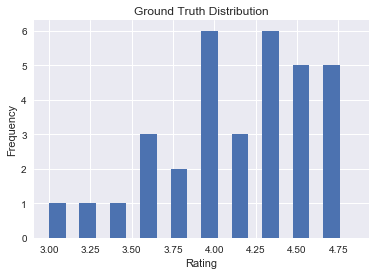

In [56]:
plt.hist(rank_df['rating'].as_matrix(), bins=10, width=0.1)
plt.title("Ground Truth Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")

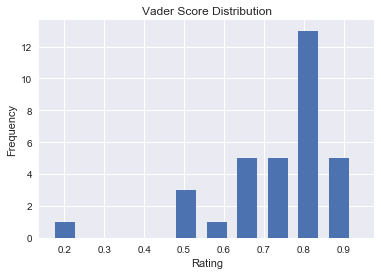

In [60]:
plt.hist(rank_df['vader'].as_matrix(), bins=10, width=0.05)
plt.title("Vader Score Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")

In general, the two correlates very well, both of them are skewed right, which is more significant in Vader score distribution.

### (b)

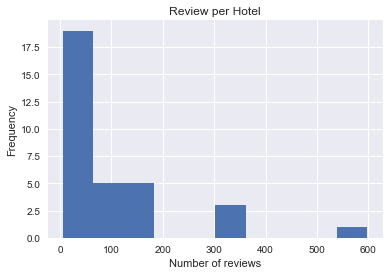

In [62]:
plt.hist(review_df['hotelName'].value_counts().as_matrix(), bins=10)
plt.title("Review per Hotel")
plt.xlabel("Number of reviews")
plt.ylabel("Frequency")

We can see the overall distribution skews left, and the hotels with more than 300 reviews are highly rare, because most people would not leave a review after their stay.

## Q5 (b)
### (a)

In [64]:
tp5gthotel = rank_df.sort_values('rating', ascending=0).head(5)
tp5gthotel

,hotelName,vader,rating
18,Nita Lake Lodge,0.932881,4.841137
11,Four Seasons Resort and Residences Whistler,0.911043,4.800000
10,First Tracks Lodge,0.819605,4.767857
19,Pan Pacific Whistler Mountainside,0.793395,4.712329
7,Evolution,0.844805,4.682927


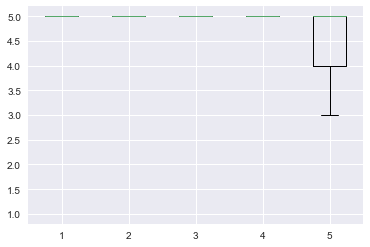

In [70]:
top1 = review_df.loc[review_df['hotelName'] == tp5gthotel['hotelName'].as_matrix()[0]]['rating']
top2 = review_df.loc[review_df['hotelName'] == tp5gthotel['hotelName'].as_matrix()[1]]['rating']
top3 = review_df.loc[review_df['hotelName'] == tp5gthotel['hotelName'].as_matrix()[2]]['rating']
top4 = review_df.loc[review_df['hotelName'] == tp5gthotel['hotelName'].as_matrix()[3]]['rating']
top5 = review_df.loc[review_df['hotelName'] == tp5gthotel['hotelName'].as_matrix()[4]]['rating']

data = [top1, top2, top3, top4, top5]
plt.figure()
plt.boxplot(data)
plt.show()

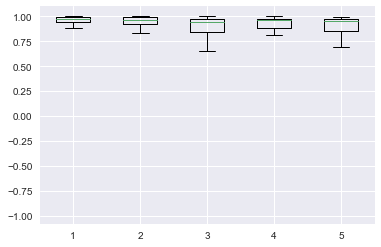

In [71]:
vtop1 = review_df.loc[review_df['hotelName'] == tp5gthotel['hotelName'].as_matrix()[0]]['vader']
vtop2 = review_df.loc[review_df['hotelName'] == tp5gthotel['hotelName'].as_matrix()[1]]['vader']
vtop3 = review_df.loc[review_df['hotelName'] == tp5gthotel['hotelName'].as_matrix()[2]]['vader']
vtop4 = review_df.loc[review_df['hotelName'] == tp5gthotel['hotelName'].as_matrix()[3]]['vader']
vtop5 = review_df.loc[review_df['hotelName'] == tp5gthotel['hotelName'].as_matrix()[4]]['vader']

data = [vtop1, vtop2, vtop3, vtop4, vtop5]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

### (b)

In [72]:
print('Grount truth scores:\n')
print('Nita Lake Lodge:                             mean {:.3f}, var {:.3f}'.format(np.array(top1).mean(), np.array(top1).var()))
print('Four Seasons Resort and Residences Whistler: mean {:.3f}, var {:.3f}'.format(np.array(top2).mean(), np.array(top2).var()))
print('First Tracks Lodge:                          mean {:.3f}, var {:.3f}'.format(np.array(top3).mean(), np.array(top3).var()))
print('Pan Pacific Whistler Mountainside:           mean {:.3f}, var {:.3f}'.format(np.array(top4).mean(), np.array(top4).var()))
print('Evolution:                                   mean {:.3f}, var {:.3f}'.format(np.array(top5).mean(), np.array(top5).var()))

Grount truth scores:

Nita Lake Lodge:                             mean 4.841, var 0.157
Four Seasons Resort and Residences Whistler: mean 4.800, var 0.283
First Tracks Lodge:                          mean 4.768, var 0.178
Pan Pacific Whistler Mountainside:           mean 4.712, var 0.315
Evolution:                                   mean 4.683, var 0.265


In [73]:
print('Vader sentiment scores:\n')
print('Nita Lake Lodge:                             mean {:.3f}, var {:.3f}'.format(np.array(vtop1).mean(), np.array(vtop1).var()))
print('Four Seasons Resort and Residences Whistler: mean {:.3f}, var {:.3f}'.format(np.array(vtop2).mean(), np.array(vtop2).var()))
print('First Tracks Lodge:                          mean {:.3f}, var {:.3f}'.format(np.array(vtop3).mean(), np.array(vtop3).var()))
print('Pan Pacific Whistler Mountainside:           mean {:.3f}, var {:.3f}'.format(np.array(vtop4).mean(), np.array(vtop4).var()))
print('Evolution:                                   mean {:.3f}, var {:.3f}'.format(np.array(vtop5).mean(), np.array(vtop5).var()))

Vader sentiment scores:

Nita Lake Lodge:                             mean 0.933, var 0.031
Four Seasons Resort and Residences Whistler: mean 0.911, var 0.022
First Tracks Lodge:                          mean 0.820, var 0.105
Pan Pacific Whistler Mountainside:           mean 0.793, var 0.142
Evolution:                                   mean 0.845, var 0.105


### (c)

Boxplots are more informative to show the spread of data, as it shows quartiles and skewnesss of the distrubtion, which you can compare one hotels to the others. Mean and variance are more suitable for symmetrically distributed data, and boxplots good for asymmetrical distribution.

## Q5 (c)

### (a)

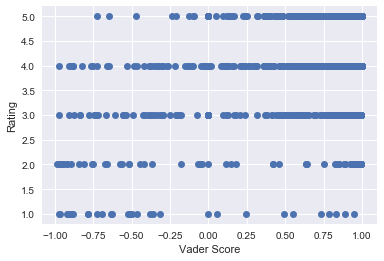

In [74]:
plt.figure()
y = review_df['rating'].as_matrix()
x = review_df['vader'].as_matrix()
plt.plot(x, y, 'o')
plt.ylabel('Rating')
plt.xlabel('Vader Score')

In [75]:
from scipy.stats.kde import gaussian_kde

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

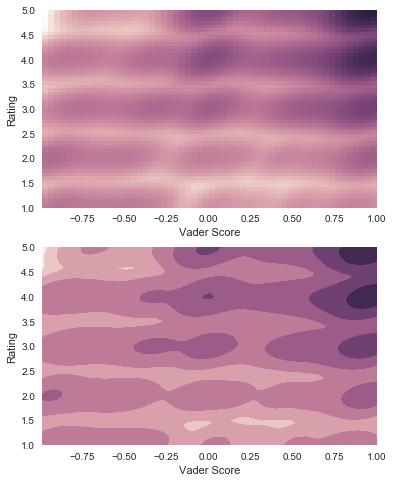

In [76]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

As seen from the scatter plot and heatmap, the ground truth rating and Vader score correlate fairly well, especially in the high score region (3.5 to 5 and 0.8 to 1 in Vader). This suggests Vader is actually a good sentiment measure.

### (b)

In [77]:
review_df['length'] = review_df['reviewCol'].str.len().fillna(0.0).astype(int)

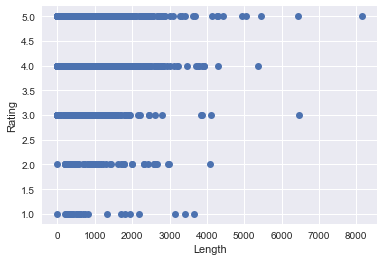

In [78]:
# plt.figure(figsize=(8,6))
y = review_df['rating'].as_matrix()
x = review_df['length'].as_matrix()
plt.plot(x, y, 'o')
plt.ylabel('Rating')
plt.xlabel('Length')

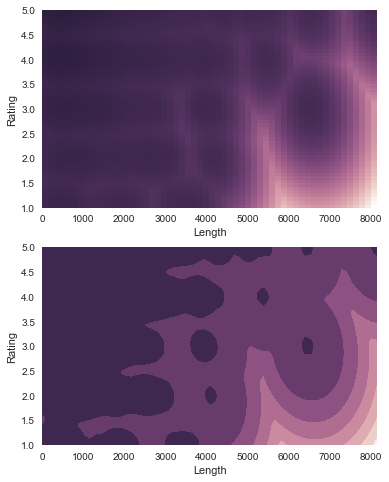

In [79]:
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Length')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Length')
ax2.set_ylabel('Rating')

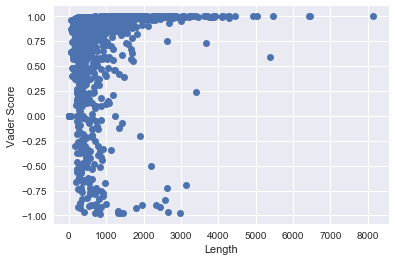

In [80]:
y = review_df['vader'].as_matrix()
x = review_df['length'].as_matrix()
plt.plot(x, y, 'o')
plt.ylabel('Vader Score')
plt.xlabel('Length')

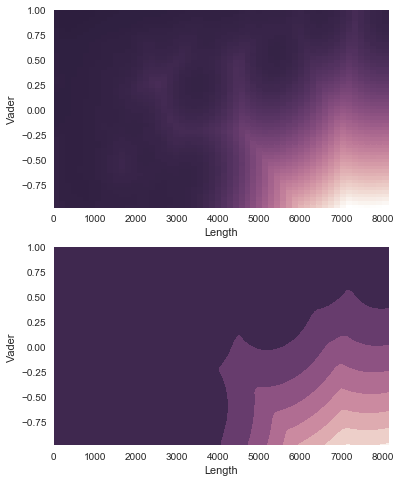

In [81]:
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Length')
ax1.set_ylabel('Vader')

ax2.set_xlabel('Length')
ax2.set_ylabel('Vader')

It is found that in both sets of results, the most of high reviews or high Vader score correlates to short reviews, less than 2000 characters.

### (c)

In [82]:
rank_df['numReviews'] = review_df['hotelName'].value_counts().reset_index().sort_values('index', ascending=1)['hotelName'].values

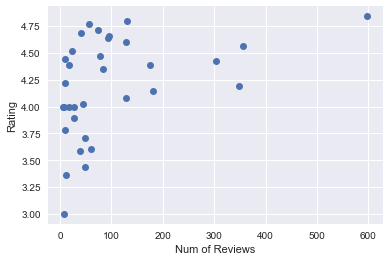

In [83]:
y = rank_df['rating'].as_matrix()
x = rank_df['numReviews'].as_matrix()
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Num of Reviews')

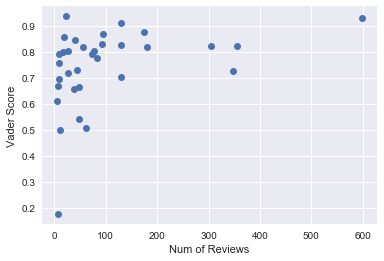

In [84]:
y = rank_df['vader'].as_matrix()
x = rank_df['numReviews'].as_matrix()
plt.plot(x, y, 'o')
plt.ylabel('Vader Score')
plt.xlabel('Num of Reviews')

Most of the higher sentment or rating are aggregated to around 0 to 100 reviews.